In [126]:
import sys
sys.path.append('../')

In [127]:
import numpy as np
from fairlearn.datasets import fetch_acs_income
from sklearn import preprocessing
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import equalized_odds_difference
import numpy as np
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource


import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# load dataset
import pandas as pd
from fairlearn.reductions import EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import Fairlearn_Model, Sklearn_Model

from sklearn.metrics import auc, roc_auc_score

# load dataset

In [128]:
data = fetch_acs_income(as_frame=False,states=["CA"])
sex = data.data[:,data['feature_names'].index('SEX')]
X = data.data
y_true = (data.target > 50000) * 1
X = preprocessing.normalize(X, norm='l2')

In [129]:
X.shape, y_true.shape

((195665, 10), (195665,))

# standard model

In [130]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
print(gm.overall)
print(gm.by_group)
print(equalized_odds_difference(y_true,
                                y_pred,
                                sensitive_features=sex))

0.7455702348401605
sensitive_feature_0
1.0    0.732420
2.0    0.760281
Name: accuracy_score, dtype: float64
0.029908267724111592


# fair models


In [131]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import equalized_odds_difference

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.7544016558914471
sensitive_feature_0
1.0    0.744606
2.0    0.765359
Name: accuracy_score, dtype: float64


In [132]:
print(equalized_odds_difference(y_true,
                                y_pred_mitigated,
                                sensitive_features=sex))


0.0006599766260567685


# Attack models

In [133]:
# for the population metric
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)

## Overlapping Indices Reference

In [134]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 2000
# num_test_points = 2000
# num_fair_train_points = 10000
# num_population_points = 30000

# train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
# test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
# population_index = np.random.choice(X.shape[0], num_population_points, replace=False)

## Overlapping Indices Non-Reference

In [135]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 2000
# num_test_points = 2000
# num_fair_train_points = 10000
# num_population_points = 30000

# train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
# test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# # fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
# population_index = train_index

## Unique Indices Reference

In [136]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 2000
# num_test_points = 2000
# num_fair_train_points = 10000
# num_population_points = 30000

# # Start with all indices
# all_indices = np.arange(X.shape[0])

# # Select train indices without replacement
# train_index = np.random.choice(all_indices, num_train_points, replace=False)
# # Remove train indices from available indices
# remaining_indices = np.setdiff1d(all_indices, train_index)

# # Select test indices from the remaining indices without replacement
# test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
# # Remove test indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, test_index)

# # Select fair train indices from the remaining indices without replacement
# fair_train_index = np.random.choice(remaining_indices, num_fair_train_points, replace=False)
# # Remove fair train indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, fair_train_index)

# # Select population indices from the remaining indices (can also choose all remaining points)
# population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

# # Summary of counts
# print(f"Number of train points: {len(train_index)}")
# print(f"Number of test points: {len(test_index)}")
# print(f"Number of fair train points: {len(fair_train_index)}")
# print(f"Number of population points: {len(population_index)}")

## Unique Indices Non-Reference

In [139]:
# Determine split sizes proportionally (to sum up to the full dataset size)
num_train_points = 2000
num_test_points = 2000
num_fair_train_points = 10000
num_population_points = 30000

# Start with all indices
all_indices = np.arange(X.shape[0])

# Select train indices without replacement
train_index = np.random.choice(all_indices, num_train_points, replace=False)
# Remove train indices from available indices
remaining_indices = np.setdiff1d(all_indices, train_index)

# Select test indices from the remaining indices without replacement
test_index = np.random.choice(remaining_indices, num_test_points, replace=False)

# Select population indices from the remaining indices (can also choose all remaining points)
population_index = train_index

# Summary of counts
print(f"Number of train points: {len(train_index)}")
print(f"Number of test points: {len(test_index)}")
print(f"Number of population points: {len(population_index)}")

Number of train points: 2000
Number of test points: 2000
Number of population points: 2000


In [141]:
combined_indices = np.concatenate([train_index, test_index])
assert len(combined_indices) == len(np.unique(combined_indices)), "Overlapping indices detected!"

In [142]:
combined_indices = np.concatenate([population_index, test_index])
assert len(combined_indices) == len(np.unique(combined_indices)), "Overlapping indices detected!"

In [143]:
input_shape= X.shape[-1]
num_classes= 1

In [144]:
(y_true[train_index])+ (sex[train_index])*2

array([2., 3., 4., ..., 3., 3., 4.])

In [145]:
# create the target model's dataset
g_train  = (y_true[train_index])+ (sex[train_index])*2
g_test  = (y_true[test_index])+ (sex[test_index])*2
g_pop_train = (y_true[population_index])+ (sex[population_index])*2

In [146]:
# create the target model's dataset
train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y', default_group='g'
)

# create the reference dataset
population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='x', default_output='y', default_group='g'
)

In [147]:
def log(y, pre):
    e = 0.0000001
    pre = np.clip(pre, e, 1 - e)
    return - y * np.log(pre) - (1 - y) * np.log(1 - pre)

model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
model.fit(X[train_index], y_true[train_index])
target_model = Sklearn_Model(model_obj=model, loss_fn=log)
print(model)
y_pred_test= model.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sex[test_index])
y_pred_train= model.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sex[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sex[test_index]))

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10)
0.7395 sensitive_feature_0
1.0    0.753006
2.0    0.723613
Name: accuracy_score, dtype: float64
0.833 sensitive_feature_0
1.0    0.841193
2.0    0.824142
Name: accuracy_score, dtype: float64
0.1038794355072884


In [148]:
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X[train_index], y_true[train_index], sensitive_features=sex[train_index])
fair_target_model = Fairlearn_Model(model_obj=mitigator, loss_fn=log)
print(mitigator)
y_pred_test= mitigator.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sex[test_index])
y_pred_train= mitigator.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sex[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sex[test_index]))

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x000001FAC2CE2F90>,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=10),
                      nu=0.004171039892747784)
0.7355 sensitive_feature_0
1.0    0.745606
2.0    0.723613
Name: accuracy_score, dtype: float64
0.829 sensitive_feature_0
1.0    0.827719
2.0    0.830385
Name: accuracy_score, dtype: float64
0.061449561530867114


In [149]:
un_target_info_source = InformationSource(
    models=[target_model],
    datasets=[target_dataset]
)

un_reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

fair_target_info_source = InformationSource(
    models=[fair_target_model],
    datasets=[target_dataset]
)

fair_reference_info_source = InformationSource(
    models=[fair_target_model],
    datasets=[reference_dataset]
)

In [150]:
from privacy_meter import audit_report
from privacy_meter.audit_report import *


un_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=un_target_info_source,
    reference_info_sources=un_reference_info_source,
    logs_directory_names='un_log'
)
un_audit_obj.prepare()

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]


In [151]:
fair_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=fair_target_info_source,
    reference_info_sources=fair_reference_info_source,
    logs_directory_names='fair_log'
)
fair_audit_obj.prepare()

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]


In [152]:
un_audit_results = un_audit_obj.run()[0]

un_audit_result = un_audit_results[0]
print(f"Metric ID: {un_audit_result.metric_id}, Accuracy: {un_audit_result.accuracy}")

Results are stored in: ['un_log']
Results are stored in: ['fair_log']
Metric ID: reference_metric, Accuracy: [0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.50075 0.50075 0.50075 0.501   0.501   0.501   0.501
 0.501   0.501   0.50425 0.50475 0.507   0.507   0.507   0.504   0.504
 0.50675 0.5075  0.5075  0.52175 0.5405  0.54725 0.54725 0.545   0.54125
 0.524  ]


In [153]:
fair_audit_results = fair_audit_obj.run()[0]

fair_audit_result = fair_audit_results[0]
print(f"Metric ID: {fair_audit_result.metric_id}, Accuracy: {fair_audit_result.accuracy}")

Results are stored in: ['fair_log']
Metric ID: reference_metric, Accuracy: [0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5     0.5
 0.5     0.5     0.49975 0.49975 0.49975 0.50025 0.50025 0.50025 0.50025
 0.50025 0.50025 0.50025 0.50025 0.50025 0.50025 0.50025 0.5005  0.50075
 0.50075 0.50075 0.50075 0.50075 0.50075 0.49875 0.50025 0.5     0.5
 0.5     0.49975 0.5     0.5     0.5015  0.50225 0.5025  0.50275 0.50325
 0.506   0.50525 0.50525 0.505   0.5035  0.50775 0.507   0.50525 0.51225
 0.51525 0.53325 0.533   0.54175 0.5515  0.55    0.548   0.548   0.55075
 0.543  ]


Text(0, 0.5, 'True Positive Rate')

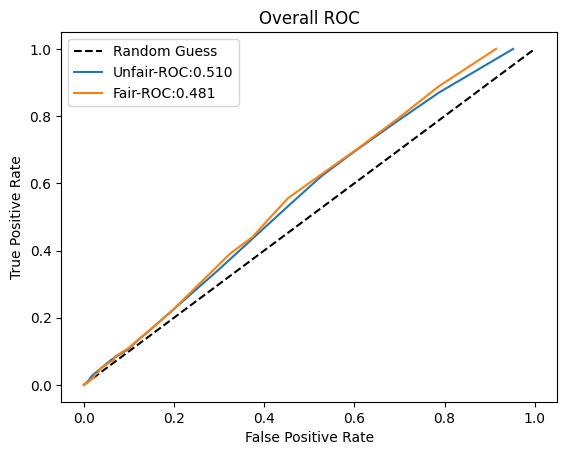

In [154]:
tpr = un_audit_results[0].tp/(un_audit_results[0].tp+un_audit_results[0].fn)
fpr = un_audit_results[0].fp/(un_audit_results[0].fp+un_audit_results[0].tn)
roc = np.trapz(tpr, fpr)
fair_tpr = fair_audit_results[0].tp/(fair_audit_results[0].tp+fair_audit_results[0].fn)
fair_fpr = fair_audit_results[0].fp/(fair_audit_results[0].fp+fair_audit_results[0].tn)
fair_roc = np.trapz(fair_tpr, fair_fpr)
plt.title('Overall ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}')
plt.plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [155]:
# show the results in each group
un_train_signal = un_audit_obj.metric_objects[0].member_signals
un_test_signal = un_audit_obj.metric_objects[0].non_member_signals
un_pop_signal = un_audit_obj.metric_objects[0].reference_signals

fair_train_signal = fair_audit_obj.metric_objects[0].member_signals
fair_test_signal = fair_audit_obj.metric_objects[0].non_member_signals
fair_pop_signal = fair_audit_obj.metric_objects[0].reference_signals

In [156]:
import scipy
def compute_p_value( target_value, observed_distribution):
    return scipy.stats.percentileofscore(observed_distribution, target_value)/100

p_results = {}
p_fair_results = {}

for g in np.unique(g_train):
    un_pop = un_pop_signal[g_pop_train==g]
    p_train = compute_p_value(un_train_signal[g_train==g], un_pop)
    p_test = compute_p_value(un_test_signal[g_test==g], un_pop)
    p_results[g] = {}
    p_results[g]['p'] = np.concatenate([p_train, p_test])
    p_results[g]['mem'] = np.concatenate([np.ones(len(p_train)), np.zeros(len(p_test))])


    fair_pop  = fair_pop_signal[g_pop_train==g]
    p_fair_train = compute_p_value(fair_train_signal[g_train==g], fair_pop)
    p_fair_test = compute_p_value(fair_test_signal[g_test==g], fair_pop)
    p_fair_results[g] = {}
    p_fair_results[g]['p'] = np.concatenate([p_fair_train, p_fair_test])
    p_fair_results[g]['mem'] = np.concatenate([np.ones(len(p_fair_train)), np.zeros(len(p_fair_test))])

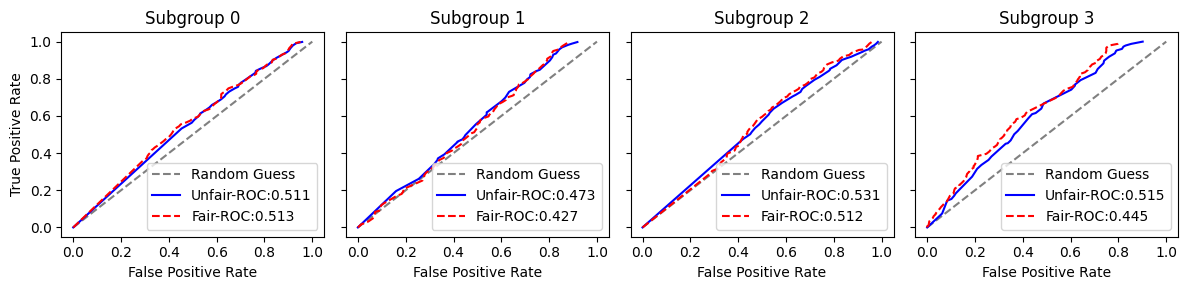

In [157]:
figs, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)

# group = np.unique(g_train)
for idx, group in enumerate(np.unique(g_train)):
    tpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    roc = np.trapz(tpr, fpr)
    fair_roc = np.trapz(fair_tpr, fair_fpr)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
    axes[idx].plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}', color='blue')
    axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}', ls='--', color='red')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_title(f'Subgroup {idx}')
    axes[idx].legend()
axes[0].set_ylabel('True Positive Rate')
plt.tight_layout()

In [158]:
for group in np.unique(g_train):
    tpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
    fpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

    fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
    fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

    # Calculate AUC for unfair and fair models
    auc_unfair = np.trapz(tpr, fpr)
    auc_fair = np.trapz(fair_tpr, fair_fpr)

    # Print AUC results for each group
    print(f"Group {group} AUC Scores:")
    print(f"Unfair Model AUC: {auc_unfair:.4f}")
    print(f"Fair Model AUC: {auc_fair:.4f}")
    print(f"{'-'*40}")

Group 2.0 AUC Scores:
Unfair Model AUC: 0.5113
Fair Model AUC: 0.5125
----------------------------------------
Group 3.0 AUC Scores:
Unfair Model AUC: 0.4726
Fair Model AUC: 0.4272
----------------------------------------
Group 4.0 AUC Scores:
Unfair Model AUC: 0.5311
Fair Model AUC: 0.5118
----------------------------------------
Group 5.0 AUC Scores:
Unfair Model AUC: 0.5146
Fair Model AUC: 0.4446
----------------------------------------


In [159]:
# Initialize dictionaries to store accuracy for each subgroup
accuracy_results = {}
accuracy_fair_results = {}

# Compute accuracy for each subgroup based on the p-values
for group in np.unique(g_train):
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    fair_accuracies = []

    for i in thresholds:
        # Unfair model accuracy
        tp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] < i)
        tn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] >= i)
        fp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] < i)
        fn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] >= i)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(accuracy)

        # Fair model accuracy
        fair_tp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i)
        fair_tn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] >= i)
        fair_fp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i)
        fair_fn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] >= i)
        fair_accuracy = (fair_tp + fair_tn) / (fair_tp + fair_tn + fair_fp + fair_fn)
        fair_accuracies.append(fair_accuracy)

    # Store the best accuracy for each subgroup
    accuracy_results[group] = max(accuracies)
    accuracy_fair_results[group] = max(fair_accuracies)

# Print the best accuracy for each subgroup
for group in accuracy_results:
    print(f"Subgroup {group}: Unfair Model Accuracy: {accuracy_results[group]:.3f}, Fair Model Accuracy: {accuracy_fair_results[group]:.3f}")

Subgroup 2.0: Unfair Model Accuracy: 0.544, Fair Model Accuracy: 0.553
Subgroup 3.0: Unfair Model Accuracy: 0.538, Fair Model Accuracy: 0.543
Subgroup 4.0: Unfair Model Accuracy: 0.549, Fair Model Accuracy: 0.564
Subgroup 5.0: Unfair Model Accuracy: 0.590, Fair Model Accuracy: 0.608


In [160]:
privacy_risks = {}  # Dictionary to store privacy risks for each subgroup
fair_privacy_risks = {}  # Dictionary to store fair privacy risks for each subgroup

# Iterate over each subgroup and calculate privacy risks
for idx, group in enumerate(np.unique(g_train)):
    # True Positive Rate (TPR) and False Positive Rate (FPR) for the "unfair" model
    tpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
    fpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

    # True Positive Rate (TPR) and False Positive Rate (FPR) for the "fair" model
    fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
    fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

    # Calculate TNR (True Negative Rate)
    tnr = [1 - rate for rate in fpr]  # TNR for the unfair model
    fair_tnr = [1 - rate for rate in fair_fpr]  # TNR for the fair model

    # Calculate Privacy Risk as the average of TPR and TNR
    privacy_risk = [(tpr[i] + tnr[i]) / 2 for i in range(len(tpr))]
    fair_privacy_risk = [(fair_tpr[i] + fair_tnr[i]) / 2 for i in range(len(fair_tpr))]

    # Store the average privacy risk for each subgroup
    privacy_risks[group] = np.mean(privacy_risk)
    fair_privacy_risks[group] = np.mean(fair_privacy_risk)

# Print the calculated privacy risks for each subgroup
for group in privacy_risks:
    print(f"Subgroup {group}: Unfair Privacy Risk = {privacy_risks[group]:.3f}, Fair Privacy Risk = {fair_privacy_risks[group]:.3f}")

Subgroup 2.0: Unfair Privacy Risk = 0.527, Fair Privacy Risk = 0.531
Subgroup 3.0: Unfair Privacy Risk = 0.527, Fair Privacy Risk = 0.523
Subgroup 4.0: Unfair Privacy Risk = 0.523, Fair Privacy Risk = 0.525
Subgroup 5.0: Unfair Privacy Risk = 0.556, Fair Privacy Risk = 0.570


# Different approach for PR, AUC, and ROC

In [161]:
# Extracting the metric results for unfair and fair models
un_metric_result, un_group_metrics = un_audit_results
fair_metric_result, fair_group_metrics = fair_audit_results

In [162]:
# Function to find the best accuracy, TPR, and TNR for each group and print results in a table-like format
def evaluate_group_metrics(unfair_group_metrics, fair_group_metrics):
    print(f"{'-'*80}")
    print(f"{'Group':<10} {'Unfair Model':<35} {'Fair Model':<35}")
    print(f"{'-'*80}")
    print(f"{'':<10} {'Privacy Risk':<15} {'AUC Score':<15} {'Privacy Risk':<15} {'AUC Score':<15}")

    # Prepare subplots for ROC curves
    figs, axes = plt.subplots(1, len(unfair_group_metrics), figsize=(12, 3), sharey=True, sharex=True)

    # Iterate through each group to calculate and print metrics for both unfair and fair models
    for idx, group in enumerate(unfair_group_metrics.keys()):
        unfair_metrics = unfair_group_metrics[group]
        fair_metrics = fair_group_metrics[group]

        # Extract privacy risk and AUC for unfair model
        unfair_privacy_risk = (unfair_metrics['tpr'] + unfair_metrics['tnr']) / 2
        unfair_true_labels = np.concatenate([np.ones(unfair_metrics['member_pred'].shape[1]), np.zeros(unfair_metrics['non_member_pred'].shape[1])])
        unfair_predicted_labels = np.concatenate([unfair_metrics['member_pred'], unfair_metrics['non_member_pred']], axis=1)
        unfair_fpr = np.sum(unfair_predicted_labels[:, unfair_true_labels == 0], axis=1) / np.sum(unfair_true_labels == 0)
        unfair_tpr = np.sum(unfair_predicted_labels[:, unfair_true_labels == 1], axis=1) / np.sum(unfair_true_labels == 1)
        unfair_auc_score = auc(unfair_fpr, unfair_tpr)

        # Extract privacy risk and AUC for fair model
        fair_privacy_risk = (fair_metrics['tpr'] + fair_metrics['tnr']) / 2
        fair_true_labels = np.concatenate([np.ones(fair_metrics['member_pred'].shape[1]), np.zeros(fair_metrics['non_member_pred'].shape[1])])
        fair_predicted_labels = np.concatenate([fair_metrics['member_pred'], fair_metrics['non_member_pred']], axis=1)
        fair_fpr = np.sum(fair_predicted_labels[:, fair_true_labels == 0], axis=1) / np.sum(fair_true_labels == 0)
        fair_tpr = np.sum(fair_predicted_labels[:, fair_true_labels == 1], axis=1) / np.sum(fair_true_labels == 1)
        fair_auc_score = auc(fair_fpr, fair_tpr)

        # Print metrics for both unfair and fair models in a table format
        print(f"{group:<10} {unfair_privacy_risk:<15.4f} {unfair_auc_score:<15.4f} {fair_privacy_risk:<15.4f} {fair_auc_score:<15.4f}")

        # Plot ROC Curve for the group
        axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
        axes[idx].plot(unfair_fpr, unfair_tpr, label=f'Unfair-ROC:{unfair_auc_score:.3f}', color='blue')
        axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_auc_score:.3f}', ls='--', color='red')
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_title(f'Subgroup {group}')
        axes[idx].legend()

    # Set shared y-label and adjust layout
    axes[0].set_ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()
    print(f"{'-'*80}\n")

--------------------------------------------------------------------------------
Group      Unfair Model                        Fair Model                         
--------------------------------------------------------------------------------
           Privacy Risk    AUC Score       Privacy Risk    AUC Score      
2.0        0.5375          0.5155          0.5525          0.5158         
3.0        0.5180          0.4836          0.5129          0.4340         
4.0        0.5388          0.5328          0.5469          0.5119         
5.0        0.5900          0.5125          0.6016          0.4443         


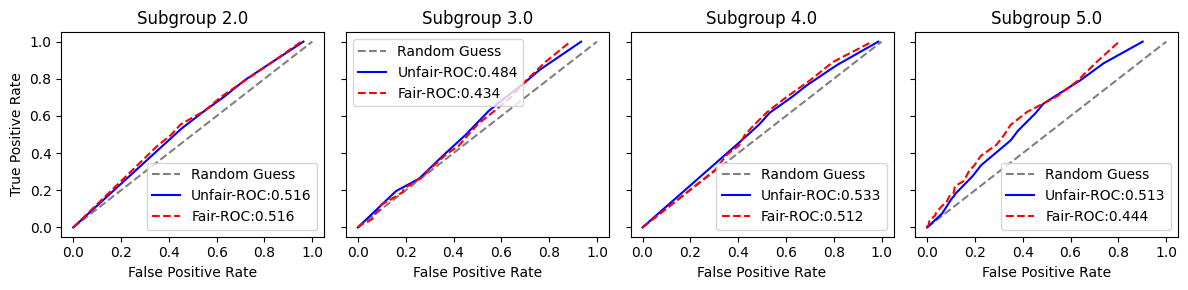

--------------------------------------------------------------------------------



In [163]:
# Evaluate group-specific metrics for both unfair and fair models
evaluate_group_metrics(un_group_metrics, fair_group_metrics)

# Prepare for next run

In [164]:
import os
import shutil

def delete_logs():
    for log_dir in ["fair_log", "un_log"]:
        if os.path.exists(log_dir):
            shutil.rmtree(log_dir)
            print(f"{log_dir} deleted.")

In [165]:
delete_logs()

fair_log deleted.
un_log deleted.
